In [1]:
# Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Data 
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets

# Neural Net
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

# **Loading Data**

In [2]:
testing_path = "../input/brain-tumor-classification-mri/Testing"
training_path = "../input/brain-tumor-classification-mri/Training"

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((250,250)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.Resize((250,250)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))
])

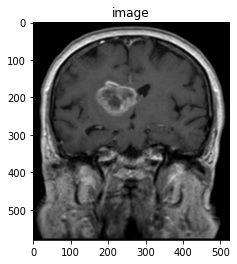

In [4]:
plt.title('image')
image = mpimg.imread("../input/brain-tumor-classification-mri/Testing/glioma_tumor/image(12).jpg")
plt.imshow(image)
plt.show()

In [5]:
train_data = datasets.ImageFolder(training_path, transform=train_transforms)
test_data = datasets.ImageFolder(testing_path, transform=test_transforms)
train_data, val_data = torch.utils.data.random_split(train_data, [2670, 200])

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=64, shuffle=True)

# **Visualizing Data**

In [7]:
def imgshow(img):
    img = img/2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

In [8]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
images.shape

(64, 3, 250, 250)

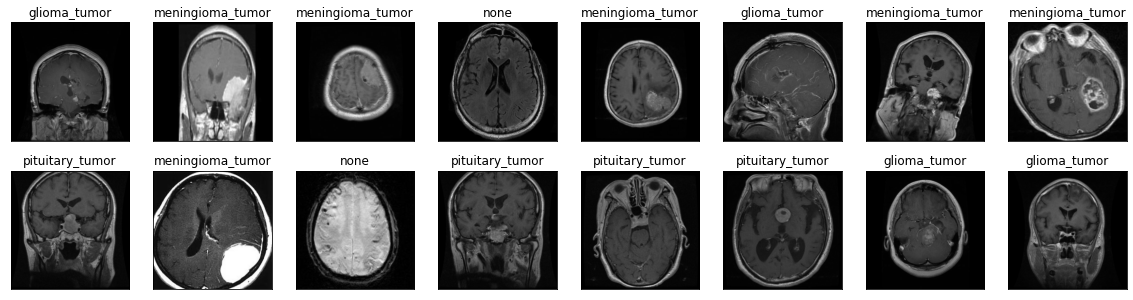

In [9]:
fig = plt.figure(figsize=(20, 5))

classes = ["glioma_tumor", "meningioma_tumor", "none","pituitary_tumor"]

for i in np.arange(16):
    ax = fig.add_subplot(2, 8, i+1, xticks=[], yticks=[])
    imgshow(images[i])
    ax.set_title(classes[labels[i]])

# **Building The Network**

In [10]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 7)
        self.conv2 = nn.Conv2d(32, 32, 7)
        self.maxpool = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(32, 64, 7)
        self.conv4 = nn.Conv2d(64, 64, 6)
        ##max
        self.fc1 = nn.Linear(64*54*54, 512)
        self.fc2 = nn.Linear(512, 4)
#       self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = (F.relu(self.conv3(x)))
        x = self.maxpool(F.relu(self.conv4(x)))
        x = x.view(-1,64*54*54)
        x = F.relu(self.fc1(x))
#       x = self.dropout(x)
        x = (self.fc2(x))
        return x
model = Net()
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_features=186624, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [12]:
epochs = 30 
min_loss = 100000

for i in range(epochs): 
    train_loss = 0 
    valid_loss = 0 
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*labels.size(0)

    model.eval()
    for images, labels in valid_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        valid_loss += loss.item()*labels.size(0)
        
    total_train_loss = train_loss/len(train_loader)
    total_valid_loss = train_loss/len(valid_loader)
    
    print("\nEpoch {}, \ntraining loss: {} \nvalidation loss: {}".format(i, total_train_loss, total_valid_loss))
    if total_valid_loss < min_loss: 
        print("loss decreased {} --> {}".format(min_loss, total_valid_loss))
        torch.save(model.state_dict(), 'model.brain.pt')
        min_loss = total_valid_loss


Epoch 0, 
training loss: 86.13855685506549 
validation loss: 904.4548469781876
loss decreased 100000 --> 904.4548469781876

Epoch 1, 
training loss: 85.46227304140727 
validation loss: 897.3538669347763
loss decreased 904.4548469781876 --> 897.3538669347763

Epoch 2, 
training loss: 83.05939644291287 
validation loss: 872.1236626505852
loss decreased 897.3538669347763 --> 872.1236626505852

Epoch 3, 
training loss: 76.56166852088202 
validation loss: 803.8975194692612
loss decreased 872.1236626505852 --> 803.8975194692612

Epoch 4, 
training loss: 56.84425899528322 
validation loss: 596.8647194504738
loss decreased 803.8975194692612 --> 596.8647194504738

Epoch 5, 
training loss: 54.90242918900081 
validation loss: 576.4755064845085
loss decreased 596.8647194504738 --> 576.4755064845085

Epoch 6, 
training loss: 52.38481155747459 
validation loss: 550.0405213534832
loss decreased 576.4755064845085 --> 550.0405213534832

Epoch 7, 
training loss: 34.08338812845094 
validation loss: 357.

In [13]:
model.load_state_dict(torch.load('model.brain.pt'))

<All keys matched successfully>

# **Testing The Network**

In [14]:
test_loss = 0.0
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))

model.eval()
for images, labels in test_loader:
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    test_loss += loss.item()
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
         print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i]))) 
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
    
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.186531

Test Accuracy of glioma_tumor:  6% ( 6/100)
Test Accuracy of meningioma_tumor: 99% (114/115)
Test Accuracy of  none: 10% (11/105)
Test Accuracy of pituitary_tumor:  1% ( 1/74)

Test Accuracy (Overall): 33% (132/394)
